# References
* Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
* Sample/starter code: https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15.ipynb

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

# Loading data from GitHub

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/1.RawData/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/1.RawData/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
train.shape, test.shape

((82332, 45), (175341, 45))

In [4]:
# Dividing the train data into attack and non-attack category
normal = train[train['label']==0]
anomaly = train[train['label']==1]

# Utility Functions

In [5]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [6]:
# Plotting pdf of numerical columns
# Refer: https://www.kaggle.com/khairulislam/unsw-nb15-eda

def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):
    """
    This function plots pdf of the given feature on attack and non-attck data
    """
    if method != None:
        sns.set_style('whitegrid')
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.set_style('whitegrid')
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()

In [7]:
def reduce_column(s, to_keep):
    """
    This function reduce categorical values of a given feature to values provided in to_keep list
    and make every other value "others"
    """
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

# Visualization
## 1. Features
### 1.1 Attacks distribution bar chart.
Getting distribution of for all the attacks.  
Plot bar char and pie chart of distribution for better visualization

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

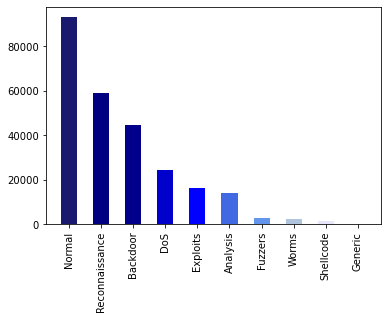

In [8]:
plt.bar(combined_data.attack_cat.unique(),
        combined_data.attack_cat.value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['midnightblue',
               'navy',
               'darkblue',
               'mediumblue',
               'blue', 
               'royalblue', 
               'cornflowerblue', 
               'lightsteelblue', 
               'lavender', 
               'lightskyblue'])
plt.xticks(rotation='vertical')
plt.savefig('distribution_bar_chart.png')
plt.show()

### 1.2 Attacks distribution pie chart.

([<matplotlib.patches.Wedge at 0x7f9332e09550>,
 [Text(0.4654704967072229, 0.996663040698877, 'Normal'),
  Text(-1.0866279471333316, 0.1709962119720845, 'Reconnaissance'),
  Text(-0.4945025009453456, -0.9825819439409615, 'Backdoor'),
  Text(0.40004113575353367, -1.0246790178904919, 'DoS'),
  Text(0.8387714234046985, -0.7116617871430616, 'Exploits'),
  Text(1.0393251377247725, -0.3602821923067843, 'Analysis'),
  Text(1.090644197435221, -0.14316156816996317, 'Fuzzers'),
  Text(1.097345720968709, -0.07636994612846441, 'Worms'),
  Text(1.0997174710924, -0.024929576292758538, 'Shellcode'),
  Text(1.0999975248432161, -0.0023335249727840894, 'Generic')],
 [Text(0.25389299820393973, 0.5436343858357511, '36.09%'),
  Text(-0.5927061529818171, 0.09327066107568245, '22.85%'),
  Text(-0.2697286368792794, -0.5359537876041608, '17.28%'),
  Text(0.2182042558655638, -0.5589158279402682, '9.41%'),
  Text(0.4575116854934718, -0.3881791566234881, '6.35%'),
  Text(0.5669046205771486, -0.19651755944006416, 

Text(0.5, 1.0, 'Distribution')

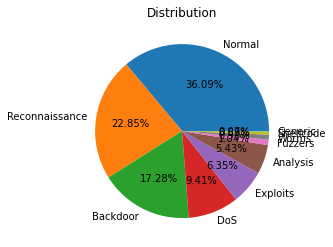

In [9]:
plt.pie(combined_data.attack_cat.value_counts(), labels=combined_data.attack_cat.unique(), autopct='%1.2f%%')
plt.title('Distribution')
plt.savefig('distribution_pie_chart.png')
plt.show()

### 1.3 Protocol
* The no of unique values of 'proto' in dataset where attack is normal is 7 but in anamoly category its 129. So to plot it we are reducing the no of values.
* Most of the values are consists of udp and tcp
* For non-attacks count of tcp is lot higher
* Considering the imbalce there are lots of udp cat for attacks

In [10]:
train['proto'].nunique()

131

In [11]:
normal['proto'].nunique(), anomaly['proto'].nunique()

(5, 129)

In [12]:
train['proto'].value_counts().head(10)*100/train.shape[0]

tcp     52.342953
udp     35.730943
unas     4.269300
arp      1.198805
ospf     0.821066
sctp     0.393529
any      0.116601
gre      0.106884
rsvp     0.077734
ipv6     0.074090
Name: proto, dtype: float64

In [13]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

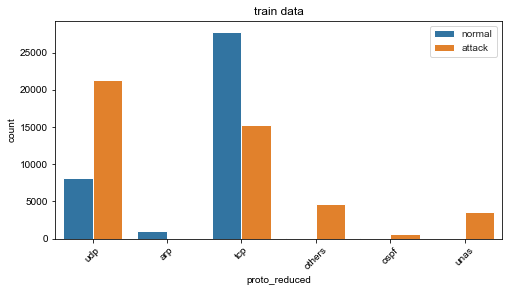

In [14]:
col_countplot('proto_reduced')

### 1.4 Service

* In our dataset we can value "-" that is null, we need to remove that and replace it.
* For normal there are lots of others that means most of "-" and few rare values.
* In attack data "dns" is present higher than any other values. There are few no of others and http also.

In [15]:
train['service'].nunique()

13

In [16]:

train['service'].value_counts()

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64

In [17]:

to_keep = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
train['service_reduced'] = train['service'].apply(reduce_column, args=(to_keep,))

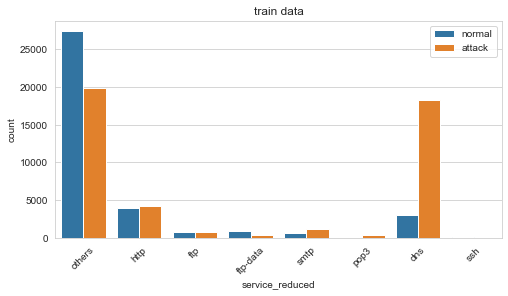

In [18]:
col_countplot('service_reduced')

### 1.5 State
* Reducing very rare values with "others" to plot and visualize better
* For non-attacks "fin" is very frequent then "cons" almost half of "fin" and few "int" also.
* In attack "int" is higher than normal cat values. That could be really important feature to detect. There are very few "fin"

In [19]:
train['state'].nunique()

7

In [20]:
train['state'].value_counts()

FIN    39339
INT    34163
CON     6982
REQ     1842
ACC        4
RST        1
CLO        1
Name: state, dtype: int64

In [21]:
to_keep = ['int', 'fin', 'con', 'req']
train['state_reduced'] = train['state'].apply(reduce_column, args=(to_keep,))

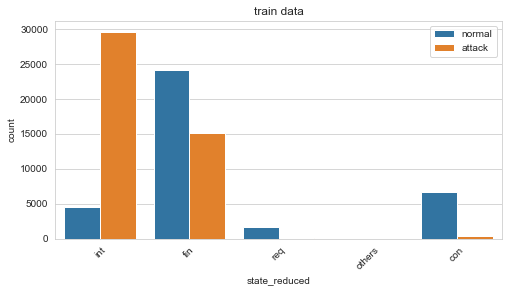

In [22]:
col_countplot('state_reduced')

In [23]:
train.drop(columns=['proto_reduced', 'state_reduced', 'service_reduced'], inplace=True)

In [24]:
train.shape

(82332, 45)

### 1.6 ct_dst_ltm
Numerical feature.  
No. of connections of the same destination address in 100 connections according to the last time.  
* Range of values of this feature is about 0 to 70
* For normal data most of the values are between 0 to 10 and few from 10 to 20.
* For anomaly values are close to 0 and also there are values from 10 to 30.
* Can visualize better after using log1p on the feature

In [25]:
col = 'ct_dst_ltm'
train[col].nunique()

50

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

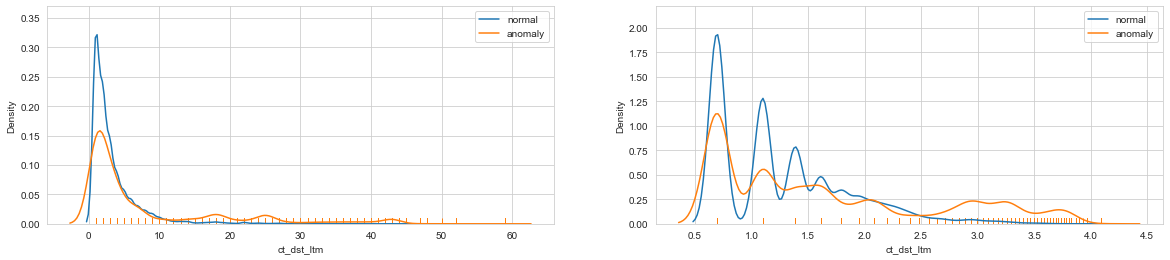

In [26]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### 1.7 ct_flw_http_mthd
Numerical feature with small discreate set of values.  
No. of flows that has methods such as Get and Post in http service.
* For normal almost all the values are 0 and few 1.
* In attack data everything is 0 and there is very very litle no of 1's

In [27]:
train['ct_flw_http_mthd'].nunique()

8

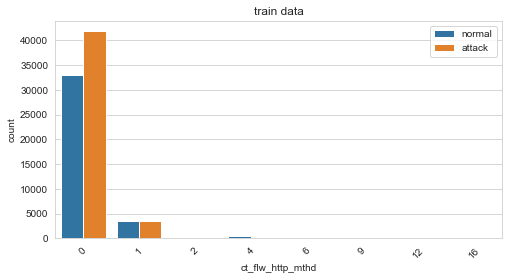

In [28]:
col_countplot('ct_flw_http_mthd')

### 1.8 ct_srv_src
Numerical feature.  
No. of connections that contain the same service and source address in 100 connections according to the last time.
* Range of the values is between 0 to 70.
* For normal most of the values are from 0 to 15.
* For anomaly most of the values are from 0 to 10 and the values are also distributed between 15 to 50.

In [29]:
col = 'ct_srv_src'
train[col].nunique()

57

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

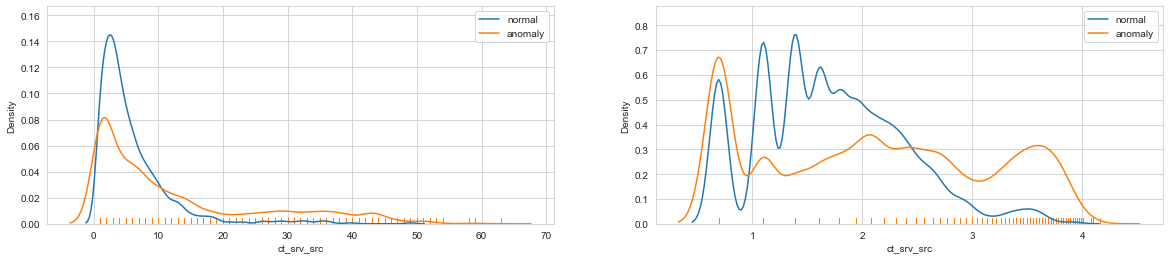

In [30]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### 1.9 ct_state_ttl
Numerical feature with small discrete set of values.
* normal data has 0 as most of its values.
* anomaly has most of its value 2.
* There are few attack with value 1 to and also very little non-attack with 1.

In [31]:
train['ct_state_ttl'].nunique()


7

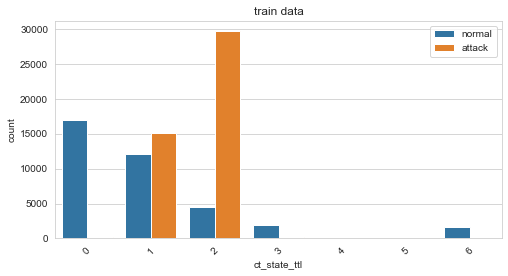

In [32]:

col_countplot('ct_state_ttl')

### 1.10 djit
Numerical feature. Destination jitter (mSec)
* Range of this feature is huge upto 800,000.
* Normal data distributed over very wide range upto 200,000.
* For attack data there is a huge peek close to 0 and distributioon of values are very narrow.

In [33]:
train['djit'].nunique()

38381

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

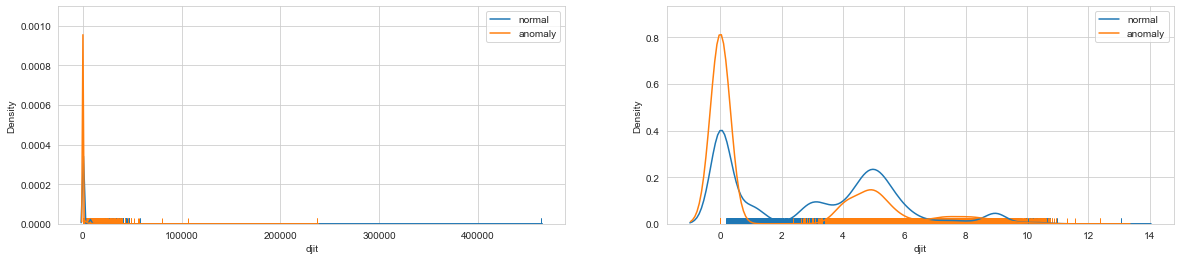

In [34]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('djit')
plt.subplot(122)
dual_plot('djit', method=np.log1p)
plt.show()

### 1.11 dload
Numerical feature. Destination bits per second
* This feature has high correlation with target feat, 0.35
* Feature has huge range of values upto 1e8
* We can visualize better in log scale. For normal data they are distributed all over, has values close to 0 and also very large values
* And for attack data all the values are very close to 0. IN log scale we can see that values are between 3 to 15

In [35]:
train['dload'].nunique()

40614

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

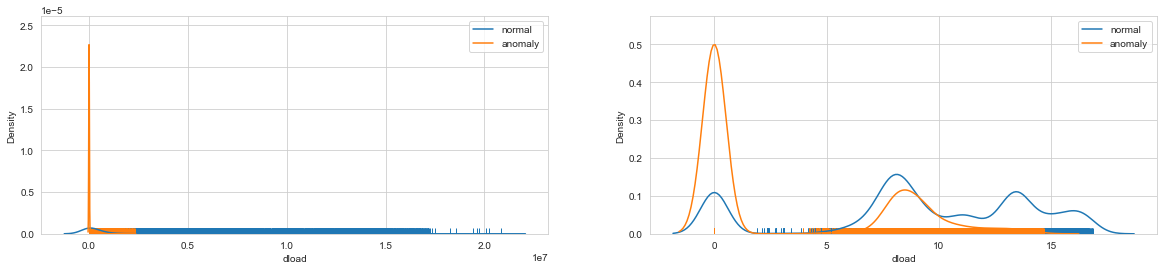

In [36]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('dload')
plt.subplot(122)
dual_plot('dload', method=np.log1p)
plt.show()

### 1.12 dbytes

Numerical feature. Destination to source bytes.
* The range of values for this feature is very wide upto 1e7.
* Values of normal categories are grouped together. In log scale can see there are values close to 0 and then from 5 to 12.
* For attck category data values are widely spread. In log scale can see high peeks around 5 to 7.

In [37]:
col = 'dbytes'
train[col].nunique()

4034

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

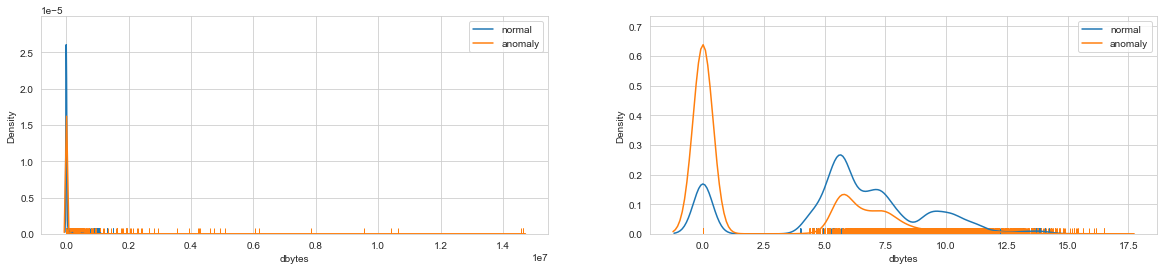

In [38]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### 1.13 dpkts

Numerical feature. Destination to source packet count
* Range of values for this feature is around 10,000
* Non-attck cat values are very close to 0. In log scale its upto 5.
* Attack cat values are widely distributed and has higher fraction around 2 and 3 in log1p graph

In [39]:
col = 'dpkts'
train[col].nunique()

436

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

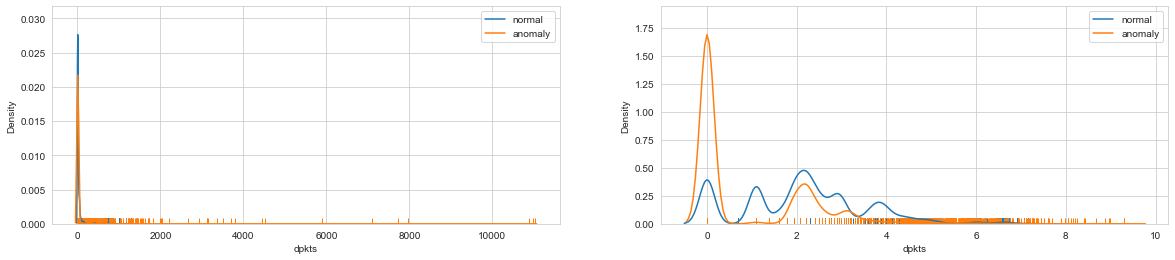

In [40]:

plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('dpkts')
plt.subplot(122)
dual_plot('dpkts', method=np.log1p)
plt.show()

### 1.14 dtcpb
Numerical features. Destination TCP sequence number
* The range of this feature is very very wide 4*10^9
* Values of normal cat are lot more wide spread than anomaly cat.
* From the graphs its not much clear about the distribution. But can see attack cat values are distributed through out total range.

In [41]:
col = 'dtcpb'
train[col].nunique()

39108

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

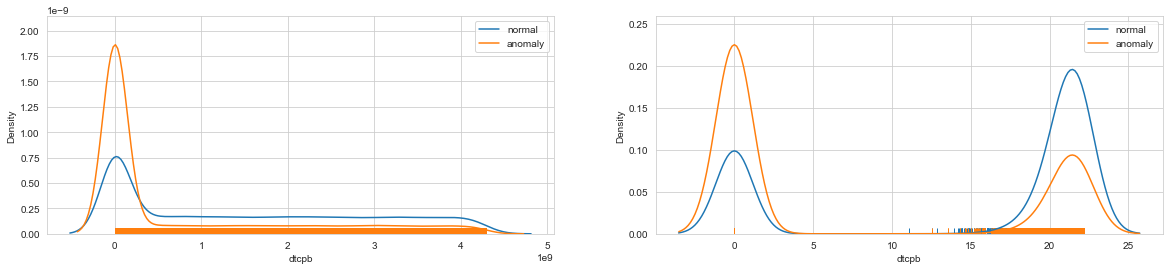

In [42]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()


### 1.15 dttl
Destination to source time to live  
Numerical feature with only 11 unique value. Can plot it as categorical feature.  
Destination to source time to live
* Most of the values for non-attack data is 29. There are some 0 and very few 252.
* There lots of 0 in attack data, no of 0 in attack is more than non-attack, there are few 252 also and that is also higher than non-attack.

In [43]:
train['dttl'].nunique()

8

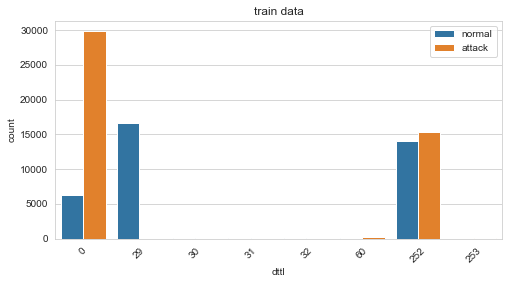

In [44]:
col_countplot('dttl')

### 1.16 dur
Numerical feature. Record total duration
* Range of this feature is 0 to 8000
* Both attack and non-attack cat values are very close to 0.
* But attack cat values are widely distributed than non-attack.


In [45]:

col = 'dur'
train[col].nunique()

39888

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

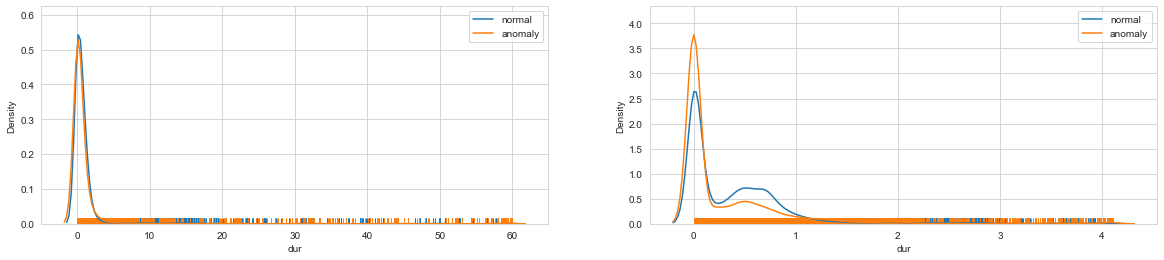

In [46]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()


### 1.17 sttl
Numerical feature with only 13 unique value. 
* Source to destination time to live
* normal cat data has most of its values 31 and few 60.
* anomaly cat has almost all of its value 254.

In [47]:

train['sttl'].nunique()

11

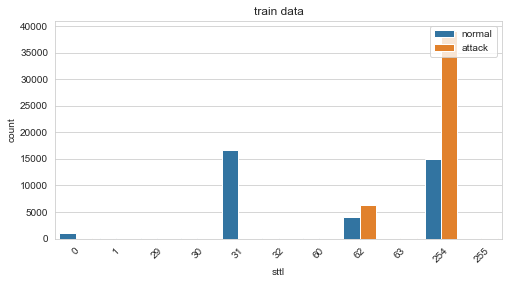

In [48]:
col_countplot("sttl")

### 1.18 stcpb
Numerical feature. Source TCP sequence number
* The graphs are very similar to 'dtcpb'
* normal cat has higher no of values close to 0 and has spread through out whole range
* anomaly has most of its values near 0 and less spread compared to normal cat.

In [49]:
col = 'stcpb'
train[col].nunique()

39219

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

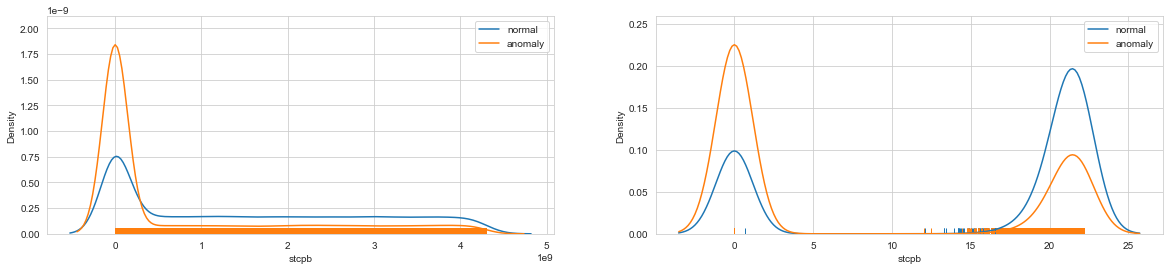

In [50]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()


### 1.19 swin
Numerical feature with 22 unique value.  
Source TCP window advertisement
* Most of the values of this feature are just 0 and 255
* Normal cat data has most of its values 255 and 0
* Attack act has large no of 0 and small no of 255, just the inverse of normal cat.

In [51]:

train['swin'].nunique()

11

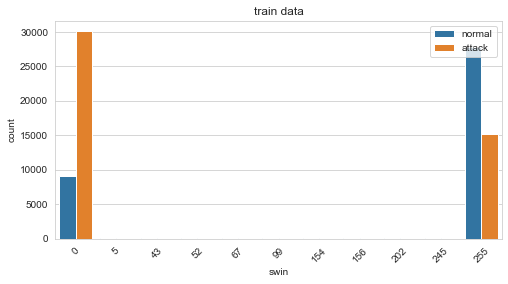

In [52]:
col_countplot('swin')

### 1.20 sbytes
Source to destination bytes  
Numerical feature with large range of values upto 1e7
* Most of normal cat values are close to 0.
* Attack cat has most of its values around 5 in log1p graph.
* The spread of values is wider in attack compared to normal.

In [53]:
col = 'sbytes'
train[col].nunique()

4489

<Figure size 1440x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

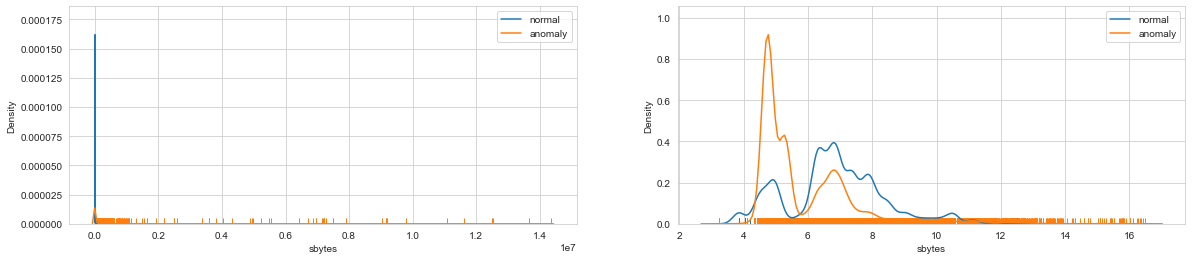

In [54]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

## 2. Correlation
Getting correlation values for all the features.  
Plot heatmap of correaltion for better visualization

In [55]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [56]:
def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

<Figure size 864x864 with 0 Axes>

<AxesSubplot:>

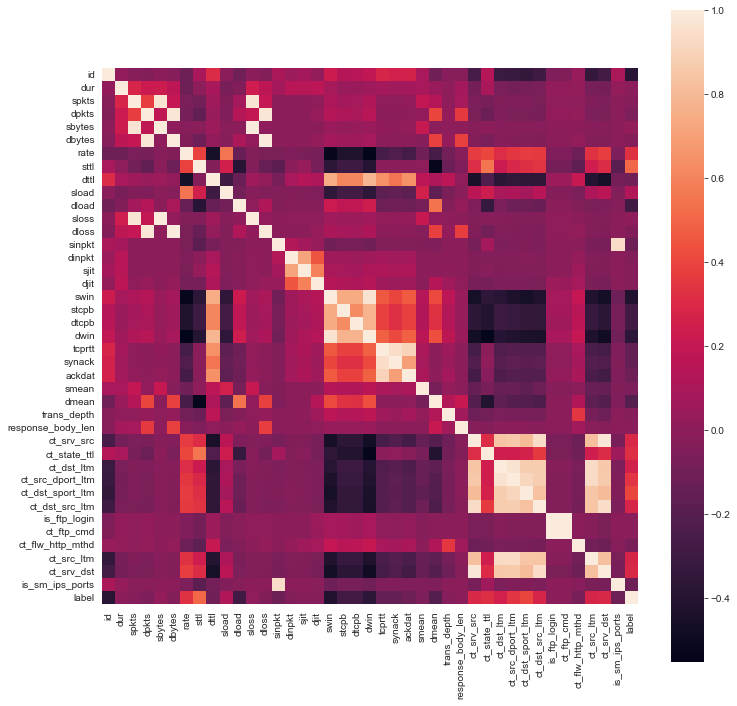

In [57]:

# Plotting the correlation matrix of the dataset
# Refer: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [58]:
# Getting and printing high correlated features
limit = 0.9

columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

spkts                sbytes               0.9657497410287414
spkts                sloss                0.9736439932787799
dpkts                dbytes               0.9764185516958216
dpkts                dloss                0.9815064328008422
sbytes               sloss                0.99502719113184
dbytes               dloss                0.9971088501020646
sinpkt               is_sm_ips_ports      0.9445057600994802
swin                 dwin                 0.9601246970559344
tcprtt               synack               0.9394732071062888
ct_srv_src           ct_dst_src_ltm       0.9337952137616565
ct_srv_src           ct_srv_dst           0.9778491535974652
ct_dst_ltm           ct_src_dport_ltm     0.9604008284955233
ct_dst_ltm           ct_src_ltm           0.9322524473427766
ct_src_dport_ltm     ct_dst_sport_ltm     0.9116374681078989
ct_src_dport_ltm     ct_src_ltm           0.9331720623302827
ct_dst_src_ltm       ct_srv_dst           0.9410468630509295
is_ftp_login         ct_ft

Most correlated features are:

* sbytes, sloss
* dpkts, dbytes, dloss
* sttl, ct_state_ttl, label
* swin, dwin
* stime, dtime
* tcprtt, synack, ackdat
* ct_srv_src, ct_dst_src_ltm, ct_srv_dst
* ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm